# <font color='darkblue'>Logo Removal from Egyptian ID</font>

### <font color='darkblue'>Task by:</font> Laila Masoud

### **Introduction**

In this task we are given a picture of an Egyptian national id, the task is to remove the logo of جمهورية
العربية مصر and replace it with the color of its background.

### **Approach**

##### ***Machine Learning Approach***

After trying OCR models like tesseract and ArabicOCR, it was found that the logo text wasn't correctly detected and the approach of OCR wasn't the best so opting for an object detection task was found more suitable.

**Steps:**
*   Find a dataset of Egyptian ids.
*   Annotate the dataset using Roboflow and apply preprocessing and augmentation if needed.
*   Train a YOLOv8 model on the annotated dataset.
*   Use OpenCV for replacing the logo with the background.

##### ***Feature Detection using SIFT Approach***
We can also follow the traditional approach to use well-established CV techniques such as feature descriptors like SIFT, this method is robust to changes in scale, rotation, and affine transformations.

**Steps:**

* Loading a query image (the id) and a template image (the logo).
* Extracting keypoints and descriptors in both images using SIFT.
* Using a feature matching technique like FLANN and performing k-NN to find the best matches.
* Applying the ratio test to filter out poor matches.
* Calculating the homography matrix to locate the logo in the query image.
* Creating a mask for the logo region in the query image.
* Using OpenCV inpainting to fill the masked region.
* Applying Gaussian blur to blend the inpainted region with the surrounding area.

### **Machine Learning Approach**

#### **Finding the Dataset**
After searching for a publicly available dataset for training the model, a [dataset](https://www.kaggle.com/datasets/mostafaebrahiem/egyptian-ids) on kaggle including 59 images of Egyptian ids was found. After going through the dataset to filter out the fake ids (ex: An id of Cristiano Ronaldo, etc.), we ended up with 46 images.

#### **Annotating the Dataset**
The next step of annotating the dataset and saving it in YOLOv8 format was performed on the online tool [Roboflow](https://roboflow.com/). The 46 images were uploaded and manually annotated. Roboflow can also be used to perform simple preprocessing and augmentation.
3 versions of the dataset were tried and the best results were found using the second version which includes the following steps:

The preprocessing included:

*   Auto-Orient: Applied
*   Resize: Stretch to 640x640

The augmentation included:


*   90° Rotate: Clockwise, Counter-Clockwise
*   Shear: ±10° Horizontal, ±10° Vertical

We ended up with 120 images, the train-validation-test splitting (80-20-20) resulted in: 111 training, 5 validation, and 4 test images.

The dataset can be found on roboflow [here](https://universe.roboflow.com/laila-ul0kc/id-itkgr/dataset/2).

#### **Training the YOLOv8 model**
Now as that the annotation is done, we can train the model on our custom dataset.
To use the dataset there are one of two methods:


*   Load it from Roboflow
*   Downloading the dataset and uploading it to drive.

I'll provide a commented cell below for loading the dataset from roboflow in Colab, but will proceed with downloading the dataset.

We will connect to GPU for training.

In [ ]:
### If you wish to load the dataset from robowflow in Colab
"""
-You can use the link provided in the previous cell, (https://universe.roboflow.com/laila-ul0kc/id-itkgr/dataset/2) to find the dataset.
-Log in to roboflow account and download the dataset using the show download code option.
-A code similar to this will show up:
"""
#!pip install roboflow
#from roboflow import Roboflow
#rf = Roboflow(api_key="############") #Insert your api key here
#project = rf.workspace("laila-ul0kc").project("id-itkgr")
#version = project.version(2)
#dataset = version.download("yolov8")

"""
Please change the data.yaml file configuarion to the correct paths in your Colab notebook.
test: /content/ID-2/test
train: /content/ID-2/train
val: /content/ID-2/valid
"""

'\nPlease change the data.yaml file configuarion to the correct paths in your Colab notebook.\ntest: /content/ID-2/test\ntrain: /content/ID-2/train\nval: /content/ID-2/valid\n'

In [1]:
!nvidia-smi

Sat May 18 19:40:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Since we are using Colab, we will mount the drive and upload our dataset to the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/ID.v2i.yolov8.zip -d /content/ID-2

Archive:  /content/drive/MyDrive/ID.v2i.yolov8.zip
 extracting: /content/ID-2/README.dataset.txt  
 extracting: /content/ID-2/README.roboflow.txt  
 extracting: /content/ID-2/data.yaml  
   creating: /content/ID-2/test/
   creating: /content/ID-2/test/images/
 extracting: /content/ID-2/test/images/31_jpg.rf.b9858fccd4b476170da9ba1fab1b0cba.jpg  
 extracting: /content/ID-2/test/images/32_jpg.rf.120db2a2c397b9a9ff18cf1ffc4caae6.jpg  
 extracting: /content/ID-2/test/images/45_jpg.rf.eef38b2bf2f980e0d6691e70e3691c23.jpg  
 extracting: /content/ID-2/test/images/7_jpg.rf.c7d725382cc04ca2c23c45098c58630b.jpg  
   creating: /content/ID-2/test/labels/
 extracting: /content/ID-2/test/labels/31_jpg.rf.b9858fccd4b476170da9ba1fab1b0cba.txt  
 extracting: /content/ID-2/test/labels/32_jpg.rf.120db2a2c397b9a9ff18cf1ffc4caae6.txt  
 extracting: /content/ID-2/test/labels/45_jpg.rf.eef38b2bf2f980e0d6691e70e3691c23.txt  
 extracting: /content/ID-2/test/labels/7_jpg.rf.c7d725382cc04ca2c23c45098c58630b.txt 

In [5]:
import os

folder_path = "/content/ID-2"
os.chdir(folder_path)

contents = os.listdir()
print(contents)

['test', 'README.roboflow.txt', 'valid', 'train', 'README.dataset.txt', 'data.yaml']


Now we shall install ultralytics to use YOLOv8.



In [6]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 kB 11.3 MB/s eta 0:00:00


In [7]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)


In [8]:
#We should edit the paths in the data.yaml file as follows:
#train: /content/ID-2/train
#val: /content/ID-2/valid
#test: /content/ID-2/test

!yolo task=detect mode=train model=yolov8m.pt data=/content/ID-2/data.yaml epochs=20 imgsz=640

100% 49.7M/49.7M [00:00<00:00, 225MB/s]
Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/ID-2/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sh

In [9]:
!yolo task=detect mode=val model=/content/ID-2/runs/detect/train/weights/best.pt data=/content/ID-2/data.yaml

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/ID-2/valid/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100% 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 1/1 [00:02<00:00,  2.97s/it]
                   all          5          5      0.986          1      0.995       0.96
Speed: 1.1ms preprocess, 42.0ms inference, 0.0ms loss, 413.3ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [10]:
!yolo task=detect mode=predict model=/content/ID-2/runs/detect/train/weights/best.pt conf=0.5 source=/content/ID-2/test/images

Ultralytics YOLOv8.2.18 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/4 /content/ID-2/test/images/31_jpg.rf.b9858fccd4b476170da9ba1fab1b0cba.jpg: 640x640 1 Egyptian-Logo, 39.2ms
image 2/4 /content/ID-2/test/images/32_jpg.rf.120db2a2c397b9a9ff18cf1ffc4caae6.jpg: 640x640 1 Egyptian-Logo, 37.1ms
image 3/4 /content/ID-2/test/images/45_jpg.rf.eef38b2bf2f980e0d6691e70e3691c23.jpg: 640x640 1 Egyptian-Logo, 37.1ms
image 4/4 /content/ID-2/test/images/7_jpg.rf.c7d725382cc04ca2c23c45098c58630b.jpg: 640x640 1 Egyptian-Logo, 37.0ms
Speed: 2.2ms preprocess, 37.6ms inference, 674.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


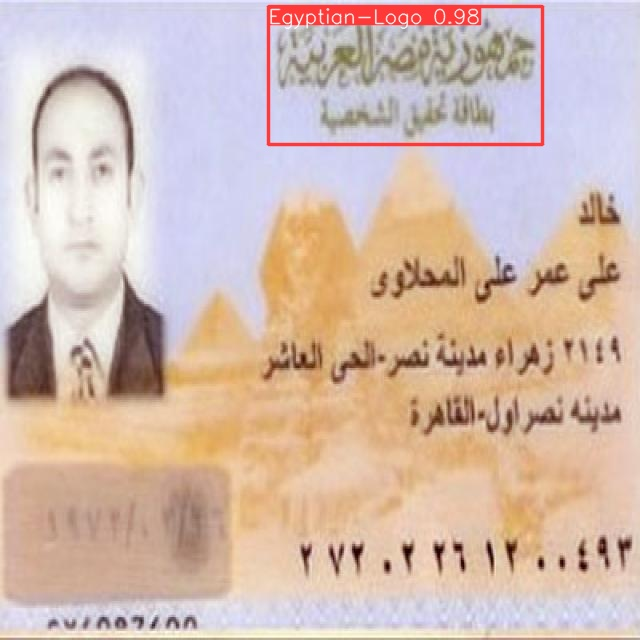

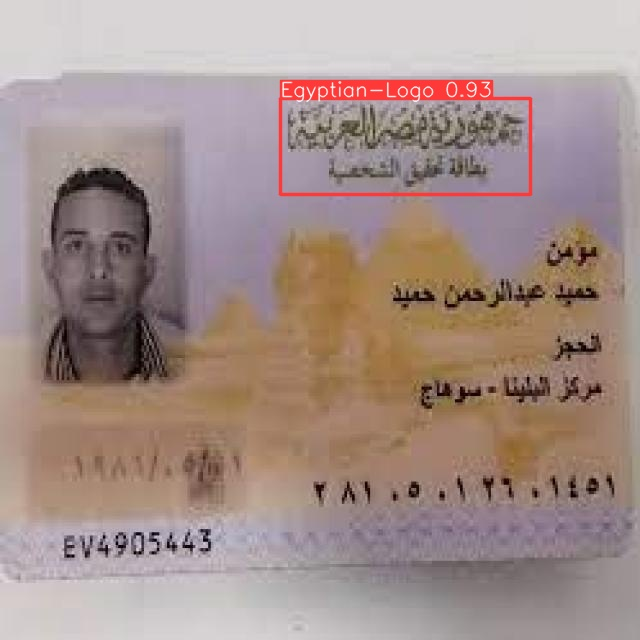

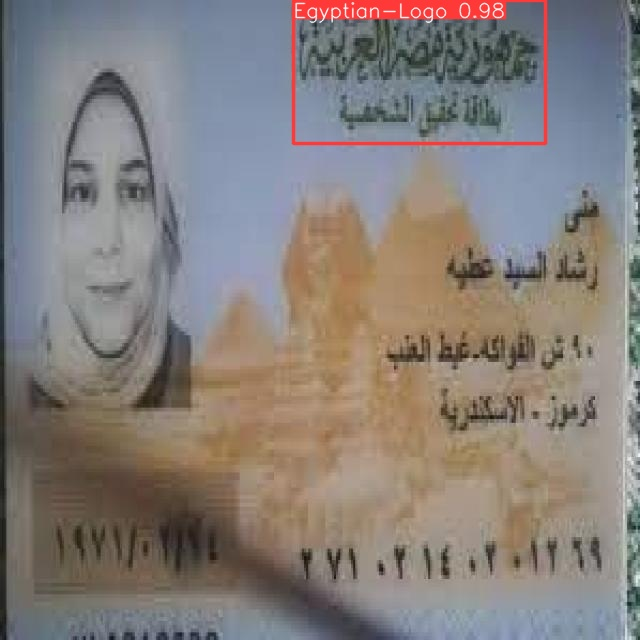

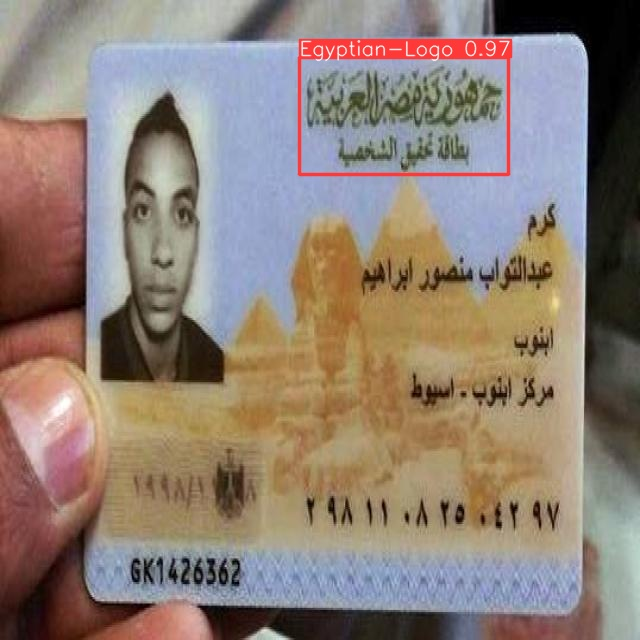

In [11]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/ID-2/runs/detect/predict/*.jpg'):
  display(Image(filename=image_path,height=600))
  print('\n')

#### **Replacing the Logo**
Now we shall perform inpainting of logo, this will be performed as follows:

1.  Applying the exported model on the image.
2.  Extracting the bounding boxes of the results.
3.  Creating a mask of the found region and applying the OpenCV inpainting function.
4.  Applying a gausian blur to the inpainted region to smoothen the result and ensure homogenity.

A function will be created for performing these steps.

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def remove_logo(input_image_path, output_image_path):
    # Load the model
    model = YOLO('/content/ID-2/runs/detect/train/weights/best.pt')

    # Load the image
    image = cv2.imread(input_image_path)

    # Run inference on the image
    results = model(input_image_path)

    # Get the first result object
    result = results[0]

    # Access the first bounding box coordinates
    box = result.boxes.xyxy[0]

    # Extract the coordinates
    x_min, y_min, x_max, y_max = map(int, box)

    # Create a mask for inpainting
    mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
    mask[y_min:y_max, x_min:x_max] = 255
    # Inpaint the area around the bounding box with the surrounding color
    inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    # Apply Gaussian blur to the inpainted region
    blurred_region = cv2.GaussianBlur(inpainted_image, (75, 75), 0)
    # Replace the inpainted region with the blurred region
    final_image = np.copy(image)
    final_image[np.where(mask == 255)] = blurred_region[np.where(mask == 255)]

    # Save the processed image to the output path
    cv2.imwrite(output_image_path, final_image)

    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

#### **Testing the Function**

We will try the function on several ids that weren't included in any of the training, validation or test. All the ids were found publicly online and are of different qualities.


In [13]:
def show_image(image_path):
    # Load the image
    original_image = cv2.imread(image_path)

    # Display the image using matplotlib
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

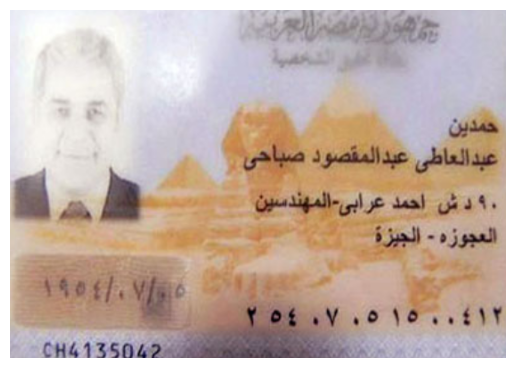

In [14]:
### Original Image
image_path = '/content/drive/MyDrive/EFG/sbahi-id.png'
show_image(image_path)

As we can see the logo is smudged and its quality is not good, the model could still detect the logo correctly.


image 1/1 /content/drive/MyDrive/EFG/sbahi-id.png: 480x640 2 Egyptian-Logos, 194.6ms
Speed: 4.7ms preprocess, 194.6ms inference, 2520.9ms postprocess per image at shape (1, 3, 480, 640)


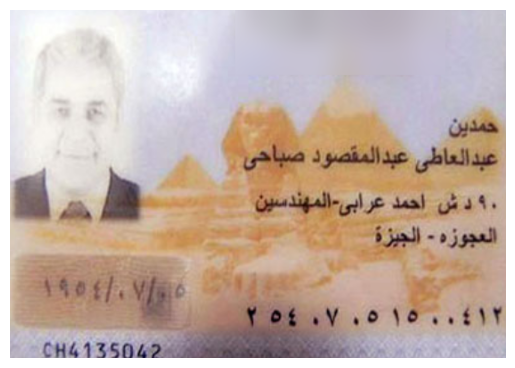

In [15]:
input_path = '/content/drive/MyDrive/EFG/sbahi-id.png'
output_path = '/content/drive/MyDrive/EFG/sbahi-id-logo-removed.png'
remove_logo(input_path, output_path)

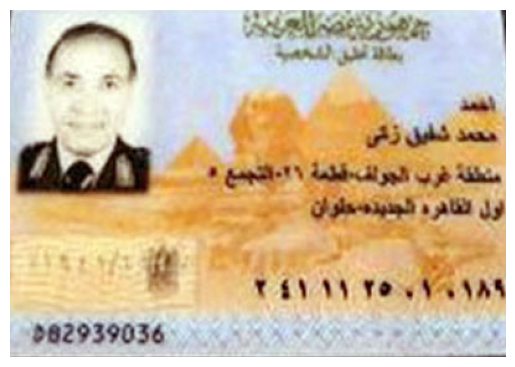

In [18]:
image_path = '/content/drive/MyDrive/EFG/shafik-ID.100.jpg'
show_image(image_path)


image 1/1 /content/drive/MyDrive/EFG/shafik-ID.100.jpg: 448x640 1 Egyptian-Logo, 107.6ms
Speed: 2.5ms preprocess, 107.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


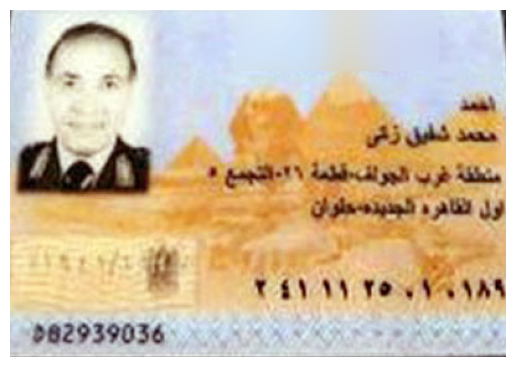

In [19]:
input_path = '/content/drive/MyDrive/EFG/shafik-ID.100.jpg'
output_path = '/content/drive/MyDrive/EFG/shafik-ID.100-logo-removed.png'
remove_logo(input_path, output_path)

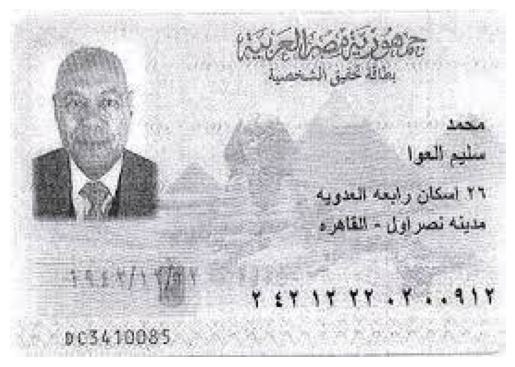

In [20]:
image_path = '/content/drive/MyDrive/EFG/elawa-id.jpg'
show_image(image_path)


image 1/1 /content/drive/MyDrive/EFG/elawa-id.jpg: 480x640 1 Egyptian-Logo, 28.8ms
Speed: 1.9ms preprocess, 28.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


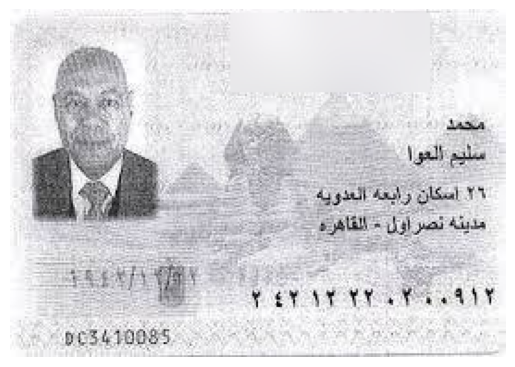

In [21]:
input_path = '/content/drive/MyDrive/EFG/elawa-id.jpg'
output_path = '/content/drive/MyDrive/EFG/elawa-id-logo-removed.png'
remove_logo(input_path, output_path)

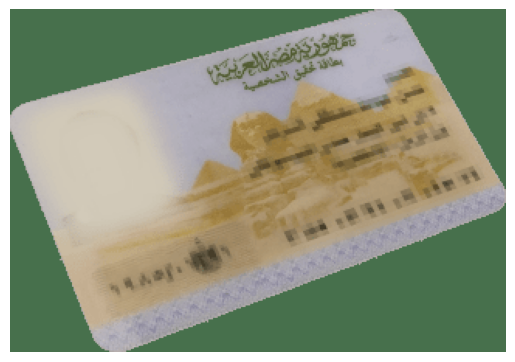

In [22]:
image_path = '/content/drive/MyDrive/EFG/fake-id.png'
show_image(image_path)


image 1/1 /content/drive/MyDrive/EFG/fake-id.png: 448x640 1 Egyptian-Logo, 28.0ms
Speed: 2.3ms preprocess, 28.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


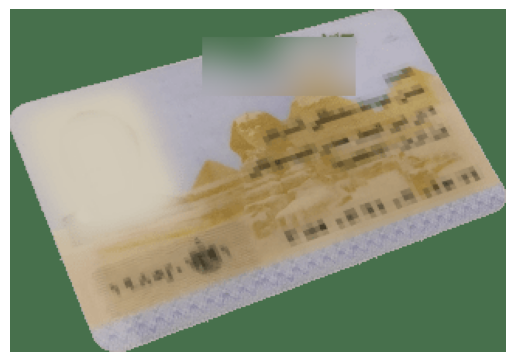

In [23]:
input_path = '/content/drive/MyDrive/EFG/fake-id.png'
output_path = '/content/drive/MyDrive/EFG/fake-id-logo-removed.png'
remove_logo(input_path, output_path)

As we can see the surrounding area color has affected the inpainting a little bit as the image is both rotated and sheared. The results may be improved by either training the model on oriented bounding boxes or segmenting the id first and then just working on the segmented id.

Using SIFT actually solves this problem without any adjustments as it's robust to such transformations.

### **Feature Detection using SIFT Approach**

The function below implements the steps mentioned in the introduction.


* Loading a query image (the id) and a template image (the logo).
* Extracting keypoints and descriptors in both images using SIFT.
* Using a feature matching technique like FLANN and performing k-NN to find the best matches.
* Applying the ratio test to filter out poor matches.
* Calculating the homography matrix to locate the logo in the query image.
* Creating a mask for the logo region in the query image.
* Using OpenCV inpainting to fill the masked region.
* Applying Gaussian blur to blend the inpainted region with the surrounding area.

#### **The template**

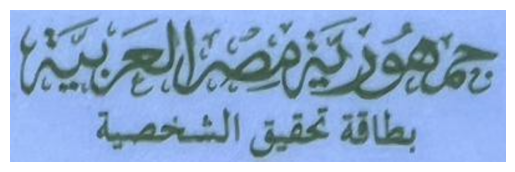

In [26]:
logo_path = '/content/drive/MyDrive/EFG/logo-real.png'
show_image(logo_path)

In [30]:
def remove_logo_sift(query_image_path, output_image_path):
    # Load query image and template image
    query_image = cv2.imread(query_image_path)
    template_image = cv2.imread('/content/drive/MyDrive/EFG/logo-real.png')

    # Convert images to grayscale
    query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template_image, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    kp_query, des_query = sift.detectAndCompute(query_gray, None)
    kp_template, des_template = sift.detectAndCompute(template_gray, None)

    # Initialize FLANN matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors
    matches = flann.knnMatch(des_template, des_query, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 10:  # Ensure there are enough good matches
        # Extract matched keypoints
        src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_query[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography matrix
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        # Get corners of the template image
        h, w = template_image.shape[:2]
        template_corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        # Transform corners using the homography matrix
        query_corners = cv2.perspectiveTransform(template_corners, M)

        # Create a mask of the same size as the query image
        mask = np.zeros(query_image.shape[:2], dtype=np.uint8)

        # Draw the filled polygon on the mask
        cv2.fillPoly(mask, [np.int32(query_corners)], 255)

        # Inpaint the area defined by the mask
        inpainted_image = cv2.inpaint(query_image, mask, 3, cv2.INPAINT_TELEA)
        # Apply Gaussian blur to the inpainted region
        blurred_region = cv2.GaussianBlur(inpainted_image, (31, 31), 0)

        # Replace the inpainted region with the blurred region
        final_image = np.copy(query_image)
        final_image[np.where(mask == 255)] = blurred_region[np.where(mask == 255)]

        # Save the inpainted image
        cv2.imwrite(output_image_path, final_image)

        return final_image

    else:
        print("Not enough good matches found to extract the logo.")
        return None

#### Some Samples

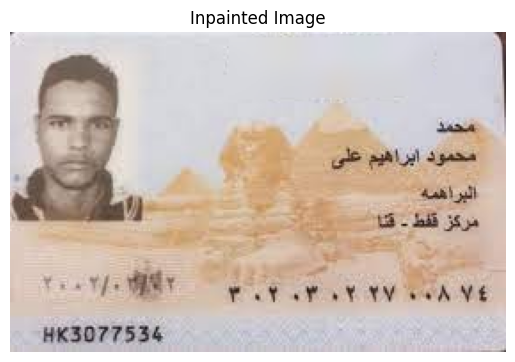

In [31]:
query_image_path = '/content/drive/MyDrive/EFG/21.jpg'
output_image_path = "/content/result.jpg"

result_image = remove_logo_sift(query_image_path, output_image_path)

if result_image is not None:
    # Display the result using matplotlib
    plt.title("Inpainted Image")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

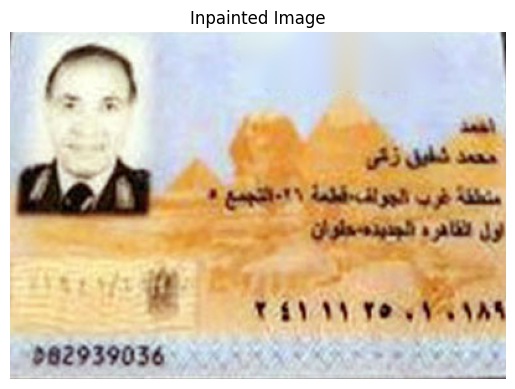

In [54]:
query_image_path = '/content/drive/MyDrive/EFG/shafik-ID.100.jpg'
output_image_path = "/content/result.jpg"

result_image = remove_logo_sift(query_image_path, output_image_path)

if result_image is not None:
    # Display the result using matplotlib
    plt.title("Inpainted Image")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

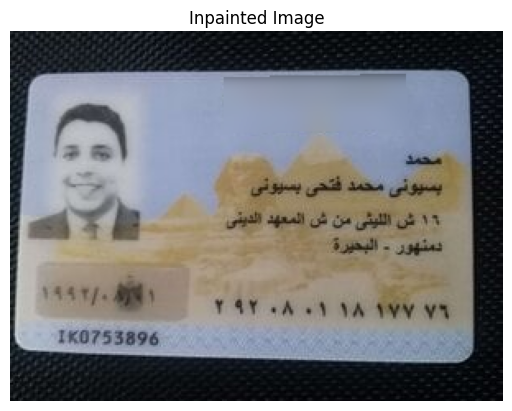

In [32]:
query_image_path = '/content/drive/MyDrive/EFG/15.jpg'
output_image_path = "/content/result.jpg"

result_image = remove_logo_sift(query_image_path, output_image_path)

if result_image is not None:
    # Display the result using matplotlib
    plt.title("Inpainted Image")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

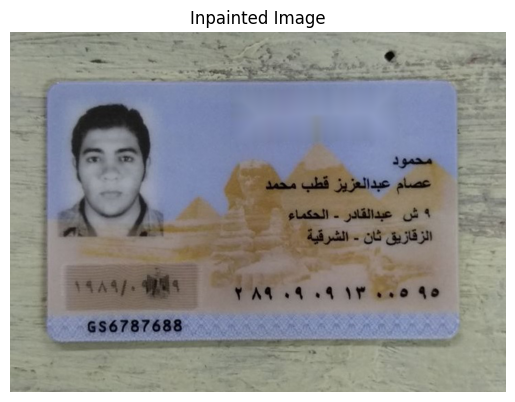

In [34]:
query_image_path = '/content/drive/MyDrive/EFG/55.jpg'
output_image_path = "/content/result.jpg"

result_image = remove_logo_sift(query_image_path, output_image_path)

if result_image is not None:
    # Display the result using matplotlib
    plt.title("Inpainted Image")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

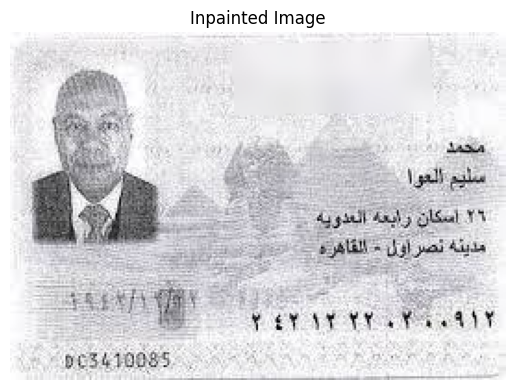

In [46]:
query_image_path = '/content/drive/MyDrive/EFG/elawa-id.jpg'
output_image_path = "/content/result.jpg"

result_image = remove_logo_sift(query_image_path, output_image_path)

if result_image is not None:
    # Display the result using matplotlib
    plt.title("Inpainted Image")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

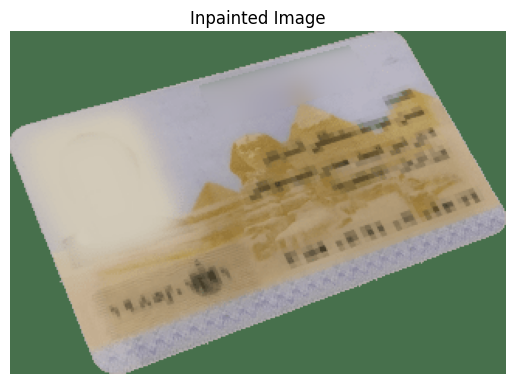

In [48]:
query_image_path = '/content/drive/MyDrive/EFG/fake-id.png'
output_image_path = "/content/result.jpg"

result_image = remove_logo_sift(query_image_path, output_image_path)

if result_image is not None:
    # Display the result using matplotlib
    plt.title("Inpainted Image")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

We can see that the algorithm performed really well on the photo that the previous method couldn't get well.

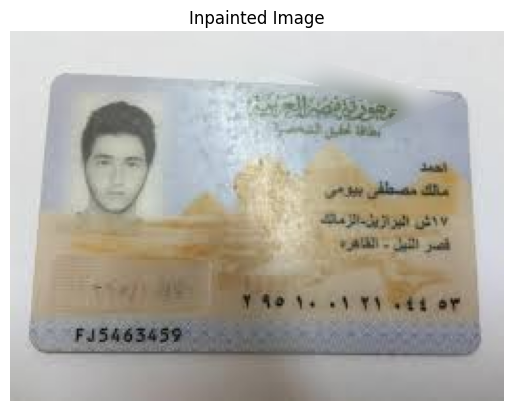

In [53]:
query_image_path = '/content/drive/MyDrive/EFG/42.jpg'
output_image_path = "/content/result.jpg"

result_image = remove_logo_sift(query_image_path, output_image_path)

if result_image is not None:
    # Display the result using matplotlib
    plt.title("Inpainted Image")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

However the algorithm couldn't detect the logo in this image for example, as it's very smudged. The yolo model will likely get this logo correctly, we won't try the model on this image though as it was trained on it.